In [1]:
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
# models
from sklearn.ensemble import GradientBoostingClassifier
# design network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from matplotlib import pyplot

%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv('gcTrianingSet.csv')

In [3]:
train['CUMSUM_cputime'] = train['cpuTimeTaken'].cumsum(axis = 0)

In [4]:
new = train[train['gcRun'] == True]

In [7]:
train.head()

,initialUsedMemory,initialFreeMemory,query token,gcRun,gcInitialMemory,gcFinalMemory,gcTotalMemory,userTime,sysTime,realTime,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime
0,4.249634,2.999878,token_1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.371230,4.409714,2.839798,0.371230
1,4.409720,2.839792,token_2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.220883,4.482361,2.767151,0.592113
2,4.482361,2.767151,token_3,False,0.0,0.0,0.0,0.0,0.0,0.0,0.141776,4.542626,2.706886,0.733889
3,4.542626,2.706886,token_4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.156459,4.616293,2.633218,0.890348
4,4.616296,2.633216,token_5,False,0.0,0.0,0.0,0.0,0.0,0.0,0.285218,4.787172,2.462339,1.175566


In [8]:
train['diff'] = train['finalUsedMemory'].values - train['initialUsedMemory'].values

In [9]:
train['freq'] = train['diff'].values / train['cpuTimeTaken'].values

In [11]:
train.describe(include='all')

,initialUsedMemory,initialFreeMemory,query token,gcRun,gcInitialMemory,gcFinalMemory,gcTotalMemory,userTime,sysTime,realTime,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime,diff,freq
count,2730.000000,2730.000000,2730,2730,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000
unique,NaN,NaN,91,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,token_49,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,30,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.775503,1.921919,NaN,NaN,0.415684,0.291495,0.479192,0.018359,0.000535,0.002755,0.186569,5.775588,1.921990,255.461629,0.000085,-0.019479
std,0.801402,0.726219,NaN,NaN,1.619302,1.132280,1.855206,0.111837,0.007700,0.016707,0.128994,0.802645,0.728086,147.136479,0.482923,2.876326
min,4.129662,0.330214,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001052,4.117682,0.330214,0.371230,-2.575007,-24.433835
25%,5.143413,1.338731,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112348,5.137244,1.337994,128.070885,0.054697,0.494437
50%,5.758096,1.961032,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141588,5.758960,1.959821,255.542042,0.076620,0.560554
75%,6.418293,2.484630,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230622,6.419282,2.484630,383.730196,0.133900,0.654622


In [12]:
train.columns

Index(['initialUsedMemory', 'initialFreeMemory', 'query token', 'gcRun',
       'gcInitialMemory', 'gcFinalMemory', 'gcTotalMemory', 'userTime',
       'sysTime', 'realTime', 'cpuTimeTaken', 'finalUsedMemory',
       'finalFreeMemory', 'CUMSUM_cputime', 'diff', 'freq'],
      dtype='object')

In [13]:
data = train.drop(['gcInitialMemory', 'gcFinalMemory', 'gcTotalMemory', 'userTime', 'sysTime', 'realTime'], axis=1)

In [14]:
data.head()

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime,diff,freq
0,4.249634,2.999878,token_1,False,0.371230,4.409714,2.839798,0.371230,0.160080,0.431215
1,4.409720,2.839792,token_2,False,0.220883,4.482361,2.767151,0.592113,0.072641,0.328867
2,4.482361,2.767151,token_3,False,0.141776,4.542626,2.706886,0.733889,0.060265,0.425069
3,4.542626,2.706886,token_4,False,0.156459,4.616293,2.633218,0.890348,0.073668,0.470844
4,4.616296,2.633216,token_5,False,0.285218,4.787172,2.462339,1.175566,0.170877,0.599111


In [15]:
newdata = data[data['gcRun'] == False]
small = newdata.groupby('query token', as_index=False)['freq'].mean()
result = data.merge(small, on='query token', right_index=True)
result = result.sort_index(axis=0)

In [20]:
ll = newdata.groupby('query token', as_index=False)['diff'].mean()
result = result.merge(ll, on='query token', right_index=True)
result = result.sort_index(axis=0)

In [23]:
train_data = result.drop(['freq_x', 'diff_x'], axis=1)

In [24]:
freeusedmemory = train_data['finalUsedMemory']
finalfreememory = train_data['finalFreeMemory']
traindata = train_data.drop(['finalUsedMemory', 'finalFreeMemory'], axis=1)

In [25]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
traindata['query token'] = encoder.fit_transform(traindata['query token'].astype('str'))
traindata['gcRun'] = encoder.fit_transform(traindata['gcRun'].astype('str'))

In [26]:
traindata = traindata.sort_index(axis=0)
cols = traindata.columns
traindata = traindata.values

In [28]:
traindata

array([[  4.24963384e+00,   2.99987788e+00,   0.00000000e+00, ...,
          3.71230016e-01,   6.96677061e-01,   1.36833050e-01],
       [  4.40971984e+00,   2.83979188e+00,   1.10000000e+01, ...,
          5.92113064e-01,   5.27401691e-01,   6.28169937e-02],
       [  4.48236098e+00,   2.76715074e+00,   2.20000000e+01, ...,
          7.33889363e-01,   4.77051433e-01,   5.54966052e-02],
       ..., 
       [  6.66385527e+00,   1.03096895e+00,   6.00000000e+01, ...,
          5.08846741e+02,   5.49357766e-01,   6.00511422e-02],
       [  6.72796255e+00,   9.66861673e-01,   3.60000000e+01, ...,
          5.09218678e+02,   8.36047402e-01,   3.09897915e-01],
       [  7.03636777e+00,   6.58456445e-01,   6.40000000e+01, ...,
          5.09334226e+02,   6.27657014e-01,   6.95381181e-02]])

In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas import DataFrame, concat
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(traindata)
# frame as supervised learning
reframed = series_to_supervised(traindata, 1, 1)
# drop columns we don't want to predict
reframed1 = reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1)
print(reframed1.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.371230   
2   4.409720   2.839792       11.0        0.0   0.220883   0.592113   
3   4.482361   2.767151       22.0        0.0   0.141776   0.733889   
4   4.542626   2.706886       33.0        0.0   0.156459   0.890348   
5   4.616296   2.633216       44.0        0.0   0.285218   1.175566   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.696677   0.136833  4.409720  
2   0.527402   0.062817  4.482361  
3   0.477051   0.055497  4.542626  
4   0.513401   0.066184  4.616296  
5   0.638627   0.158079  4.787174  


In [30]:
# split into train and test sets
values = reframed1.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 1, 8) (2000,) (729, 1, 8) (729,)


Train on 2000 samples, validate on 729 samples
Epoch 1/200
0s - loss: 5.6163 - val_loss: 6.1725
Epoch 2/200
0s - loss: 5.5754 - val_loss: 6.1445
Epoch 3/200
0s - loss: 5.5416 - val_loss: 6.1165
Epoch 4/200
0s - loss: 5.5057 - val_loss: 6.0885
Epoch 5/200
0s - loss: 5.2496 - val_loss: 5.7110
Epoch 6/200
0s - loss: 4.9145 - val_loss: 5.4462
Epoch 7/200
0s - loss: 4.8162 - val_loss: 5.3778
Epoch 8/200
0s - loss: 4.7289 - val_loss: 5.3148
Epoch 9/200
0s - loss: 4.6235 - val_loss: 5.1950
Epoch 10/200
0s - loss: 4.4651 - val_loss: 5.0174
Epoch 11/200
0s - loss: 4.3547 - val_loss: 4.9189
Epoch 12/200
0s - loss: 4.1930 - val_loss: 4.8128
Epoch 13/200
0s - loss: 3.8342 - val_loss: 4.3861
Epoch 14/200
0s - loss: 3.5241 - val_loss: 4.0115
Epoch 15/200
0s - loss: 3.1447 - val_loss: 3.5861
Epoch 16/200
0s - loss: 2.9010 - val_loss: 3.3582
Epoch 17/200
0s - loss: 2.6913 - val_loss: 3.1521
Epoch 18/200
0s - loss: 2.4810 - val_loss: 2.9577
Epoch 19/200
0s - loss: 2.2659 - val_loss: 2.7712
Epoch 20/200

0s - loss: 0.6150 - val_loss: 0.2823
Epoch 164/200
0s - loss: 0.6079 - val_loss: 0.2816
Epoch 165/200
0s - loss: 0.6139 - val_loss: 0.2958
Epoch 166/200
0s - loss: 0.6014 - val_loss: 0.2640
Epoch 167/200
0s - loss: 0.6153 - val_loss: 0.2841
Epoch 168/200
0s - loss: 0.5969 - val_loss: 0.2945
Epoch 169/200
0s - loss: 0.6010 - val_loss: 0.2633
Epoch 170/200
0s - loss: 0.5749 - val_loss: 0.4324
Epoch 171/200
0s - loss: 0.5973 - val_loss: 0.2519
Epoch 172/200
0s - loss: 0.5841 - val_loss: 0.2583
Epoch 173/200
0s - loss: 0.6073 - val_loss: 0.2512
Epoch 174/200
0s - loss: 0.5693 - val_loss: 0.2525
Epoch 175/200
0s - loss: 0.5857 - val_loss: 0.2519
Epoch 176/200
0s - loss: 0.5945 - val_loss: 0.2744
Epoch 177/200
0s - loss: 0.5664 - val_loss: 0.3032
Epoch 178/200
0s - loss: 0.5840 - val_loss: 0.2827
Epoch 179/200
0s - loss: 0.5761 - val_loss: 0.2450
Epoch 180/200
0s - loss: 0.5680 - val_loss: 0.2681
Epoch 181/200
0s - loss: 0.5678 - val_loss: 0.2420
Epoch 182/200
0s - loss: 0.5778 - val_loss: 0

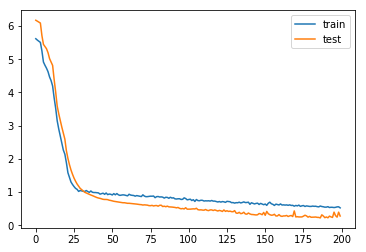

In [31]:
model1 = Sequential()
model1.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
# fit network
history = model1.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
# make a prediction
yhat = model1.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.334


In [35]:
reframed2 = reframed.drop(reframed.columns[[10,11,12,13,14,15]], axis=1)
print(reframed2.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.371230   
2   4.409720   2.839792       11.0        0.0   0.220883   0.592113   
3   4.482361   2.767151       22.0        0.0   0.141776   0.733889   
4   4.542626   2.706886       33.0        0.0   0.156459   0.890348   
5   4.616296   2.633216       44.0        0.0   0.285218   1.175566   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)  
1   0.696677   0.136833  4.409720  2.839792  
2   0.527402   0.062817  4.482361  2.767151  
3   0.477051   0.055497  4.542626  2.706886  
4   0.513401   0.066184  4.616296  2.633216  
5   0.638627   0.158079  4.787174  2.462337  


In [36]:
# split into train and test sets
values = reframed2.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 1, 9) (2000,) (729, 1, 9) (729,)


Train on 2000 samples, validate on 729 samples
Epoch 1/200
0s - loss: 1.6395 - val_loss: 1.2826
Epoch 2/200
0s - loss: 1.5385 - val_loss: 1.2327
Epoch 3/200
0s - loss: 1.4183 - val_loss: 1.1838
Epoch 4/200
0s - loss: 1.2511 - val_loss: 1.0736
Epoch 5/200
0s - loss: 1.0713 - val_loss: 0.8694
Epoch 6/200
0s - loss: 0.9213 - val_loss: 0.6974
Epoch 7/200
0s - loss: 0.7893 - val_loss: 0.6008
Epoch 8/200
0s - loss: 0.7477 - val_loss: 0.5914
Epoch 9/200
0s - loss: 0.7168 - val_loss: 0.5863
Epoch 10/200
0s - loss: 0.6912 - val_loss: 0.5852
Epoch 11/200
0s - loss: 0.6657 - val_loss: 0.5848
Epoch 12/200
0s - loss: 0.6708 - val_loss: 0.5861
Epoch 13/200
0s - loss: 0.6488 - val_loss: 0.5865
Epoch 14/200
0s - loss: 0.6476 - val_loss: 0.5869
Epoch 15/200
0s - loss: 0.6267 - val_loss: 0.5870
Epoch 16/200
0s - loss: 0.6246 - val_loss: 0.5871
Epoch 17/200
0s - loss: 0.6251 - val_loss: 0.5873
Epoch 18/200
0s - loss: 0.6225 - val_loss: 0.5876
Epoch 19/200
0s - loss: 0.6248 - val_loss: 0.5876
Epoch 20/200

0s - loss: 0.2558 - val_loss: 0.2319
Epoch 165/200
0s - loss: 0.2598 - val_loss: 0.2085
Epoch 166/200
0s - loss: 0.2698 - val_loss: 0.2390
Epoch 167/200
0s - loss: 0.2684 - val_loss: 0.2842
Epoch 168/200
0s - loss: 0.2664 - val_loss: 0.1980
Epoch 169/200
0s - loss: 0.2687 - val_loss: 0.2770
Epoch 170/200
0s - loss: 0.2643 - val_loss: 0.2693
Epoch 171/200
0s - loss: 0.2552 - val_loss: 0.2148
Epoch 172/200
0s - loss: 0.2616 - val_loss: 0.2198
Epoch 173/200
0s - loss: 0.2509 - val_loss: 0.2313
Epoch 174/200
0s - loss: 0.2588 - val_loss: 0.2569
Epoch 175/200
0s - loss: 0.2563 - val_loss: 0.2452
Epoch 176/200
0s - loss: 0.2499 - val_loss: 0.1937
Epoch 177/200
0s - loss: 0.2481 - val_loss: 0.2741
Epoch 178/200
0s - loss: 0.2689 - val_loss: 0.2473
Epoch 179/200
0s - loss: 0.2667 - val_loss: 0.2012
Epoch 180/200
0s - loss: 0.2582 - val_loss: 0.2104
Epoch 181/200
0s - loss: 0.2598 - val_loss: 0.2341
Epoch 182/200
0s - loss: 0.2562 - val_loss: 0.2040
Epoch 183/200
0s - loss: 0.2461 - val_loss: 0

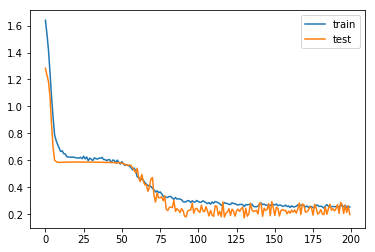

In [37]:
model2 = Sequential()
model2.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [38]:
yhat = model2.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.268


In [51]:
reframed3 = reframed.drop(reframed.columns[[8,9,10,12,13,14,15]], axis=1)
print(reframed3.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.371230   
2   4.409720   2.839792       11.0        0.0   0.220883   0.592113   
3   4.482361   2.767151       22.0        0.0   0.141776   0.733889   
4   4.542626   2.706886       33.0        0.0   0.156459   0.890348   
5   4.616296   2.633216       44.0        0.0   0.285218   1.175566   

   var7(t-1)  var8(t-1)  var4(t)  
1   0.696677   0.136833      0.0  
2   0.527402   0.062817      0.0  
3   0.477051   0.055497      0.0  
4   0.513401   0.066184      0.0  
5   0.638627   0.158079      0.0  


In [52]:
# split into train and test sets
n_train_hours = 2000
train = reframed3.iloc[:n_train_hours, :]
test = reframed3.iloc[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 8) (2000,) (729, 8) (729,)


training time:  0:00:00.146932
testing time:  0:00:00.001890
classification report: 
             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97       688
        1.0       0.48      0.34      0.40        41

avg / total       0.93      0.94      0.94       729

f1 score
0.684870317003
accuracy score
0.942386831276
confusion matrix:
[[673  15]
 [ 27  14]]


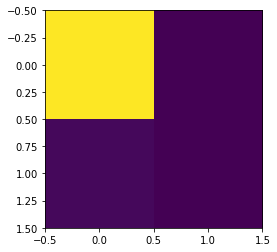

In [53]:
def testClassifier(x_train, y_train, x_test, y_test, clf):
    """
    this method will first train the classifier on the training data
    and will then test the trained classifier on test data.
    Finally it will report some metrics on the classifier performance.
    
    Parameters:
    
    x_train: (np.ndarray) train data matrix
    
    y_train: (list) train data label
    
    x_test: (np.ndarray) test data matrix
    
    y_test: (list) test data label
    
    clf: sklearn classifier object implementing fit() and predict() methods
    
    Returns:

    metrics: list
             [training time, testing time, recall and precision for every class, macro-averaged F1 score]
    """
    metrics = []
    start = dt.now()
    clf.fit(x_train, y_train)
    end = dt.now()
    print ('training time: ', (end - start))
    
    # add training time to metrics
    metrics.append(end-start)
    
    start = dt.now()
    pred = clf.predict(x_test)
    end = dt.now()
    print( 'testing time: ', (end - start))
    
    # add testing time to metrics
    metrics.append(end-start)
    
    print( 'classification report: ')
    # print classification_report(y_test, yhat)
    print (classification_report(y_test, pred))
    
    print ('f1 score')
    print (f1_score(y_test, pred, average='macro'))
    
    print ('accuracy score')
    print (accuracy_score(y_test, pred))
    
    precision = precision_score(y_test, pred, average=None)
    recall = recall_score(y_test, pred, average=None)
    
    # add precision and recall values to metrics
    for p, r in zip(precision, recall):
        metrics.append(p)
        metrics.append(r)
    
    
    #add macro-averaged F1 score to metrics
    metrics.append(f1_score(y_test, pred, average='macro'))
    
    print ('confusion matrix:')
    print (confusion_matrix(y_test, pred))
    
    # plotting the confusion matrix
    plt.imshow(confusion_matrix(y_test, pred), interpolation='nearest')
    plt.show()
    
    return metrics



gbm = GradientBoostingClassifier(n_estimators=35, learning_rate=.1,
                                max_depth=5, random_state=0, subsample=0.8, max_features=0.5)

# If we tune we can get more accuracy
boost = testClassifier(train_X, train_y, test_X, test_y, gbm)

training time:  0:00:00.140465
testing time:  0:00:00.002132
classification report: 
             precision    recall  f1-score   support

        0.0       0.99      0.93      0.96       688
        1.0       0.43      0.88      0.58        41

avg / total       0.96      0.93      0.94       729

f1 score
0.768120030008
accuracy score
0.927297668038
confusion matrix:
[[640  48]
 [  5  36]]


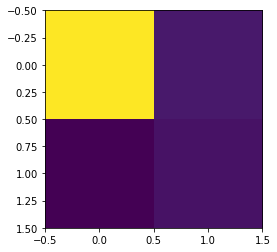

In [54]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate =0.1,
                     n_estimators=45,
                     max_depth=5,
                     min_child_weight=6,
                     gamma=0.1,
                     reg_alpha=0.01,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     objective= 'binary:logistic',
                     scale_pos_weight=8,
                     seed=27)
xgboost = testClassifier(train_X, train_y, test_X, test_y, xgb)

In [70]:
test = pd.read_csv('gcPredictionFile.csv')
test['CUMSUM_cputime'] = test['cpuTimeTaken'].cumsum(axis = 0)
test = test.merge(small, on='query token', right_index=True)
test = test.sort_index()
test = test.merge(ll, on='query token', right_index=True)
test = test.sort_index()
test['query token'] = encoder.fit_transform(test['query token'].astype('str'))
test['gcRun'] = encoder.fit_transform(test['gcRun'].astype('str'))
test.loc[:,['gcRun','cpuTimeTaken']] = test.loc[:,['cpuTimeTaken','gcRun']].values
test.columns = cols

test['gcRun'][0] = 1
test['gcRun'][0]

/home/itachi/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


1.0

In [71]:
test.fillna(value=0, inplace=True)

In [72]:
test = series_to_supervised(test, 1, 1)
# drop columns we don't want to predict
test = test.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1)
print(test.head())
column = test.columns

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.247186   2.774299        2.0        1.0   0.408436   0.408436   
2   0.000000   0.000000       73.0        0.0   0.124429   0.532865   
3   0.000000   0.000000       48.0        0.0   0.245838   0.778703   
4   0.000000   0.000000       86.0        0.0   0.169346   0.948049   
5   0.000000   0.000000       67.0        0.0   0.296311   1.244360   

   var7(t-1)  var8(t-1)  var1(t)  
1   0.520126   0.098823      0.0  
2   0.522675   0.044418      0.0  
3   0.468081   0.047545      0.0  
4   0.674019   0.125974      0.0  
5   0.732314   0.240021      0.0  


In [74]:
for i in range(test.shape[0]):
    gc = test['var4(t-1)'][i] = xgb.predict(test.iloc[i:i+1,:8])
    test = test.values
    test = test.reshape((test.shape[0], 1, test.shape[1]))
    ffm = test[i+1:i+2,:,0] = test[i:i+1,:,8:] = model1.predict(test[i:i+1,:,:8])
    fum = test[i+1:i+2,:,1] = model2.predict(test[i:i+1])
    test = test.reshape((test.shape[0], test.shape[2]))
    test = pd.DataFrame(test)
    test.columns = column
    print(gc, ffm, fum)

[ 0.] [[ 3.88057518]] [[ 2.87851763]]
[ 0.] [[ 4.24581718]] [[ 2.8222158]]
[ 0.] [[ 4.37693787]] [[ 2.70484495]]
[ 0.] [[ 4.52202225]] [[ 2.63924885]]
[ 0.] [[ 4.68718433]] [[ 2.4948101]]
[ 0.] [[ 4.57802868]] [[ 2.55331397]]
[ 0.] [[ 4.59311247]] [[ 2.52113676]]
[ 0.] [[ 4.70926476]] [[ 2.45548606]]
[ 0.] [[ 4.70512676]] [[ 2.48740673]]
[ 0.] [[ 4.69091892]] [[ 2.46387196]]
[ 0.] [[ 4.80161381]] [[ 2.41367102]]
[ 0.] [[ 4.76503229]] [[ 2.4547174]]
[ 1.] [[ 4.04961395]] [[ 2.83327627]]
[ 0.] [[ 4.31619263]] [[ 2.71503925]]
[ 0.] [[ 4.65464687]] [[ 2.47194815]]
[ 0.] [[ 4.67150307]] [[ 2.505548]]
[ 0.] [[ 4.80052376]] [[ 2.42405367]]
[ 0.] [[ 4.93999481]] [[ 2.25646377]]
[ 1.] [[ 3.78235865]] [[ 3.02662373]]
[ 0.] [[ 4.38471556]] [[ 2.69690609]]
[ 0.] [[ 4.52000237]] [[ 2.66663623]]
[ 0.] [[ 4.55606794]] [[ 2.64984703]]
[ 0.] [[ 4.57124043]] [[ 2.62633133]]
[ 0.] [[ 4.6066761]] [[ 2.57290745]]
[ 0.] [[ 4.65793419]] [[ 2.48721862]]
[ 1.] [[ 3.76070642]] [[ 3.1982069]]
[ 0.] [[ 4.06880999

[ 0.] [[ 4.44937611]] [[ 2.93212748]]
[ 0.] [[ 4.58570051]] [[ 2.82861042]]
[ 0.] [[ 4.74100876]] [[ 2.70259857]]
[ 0.] [[ 4.80319881]] [[ 2.65336084]]
[ 0.] [[ 4.84591675]] [[ 2.60629845]]
[ 0.] [[ 5.01004553]] [[ 2.44247794]]
[ 0.] [[ 5.04436398]] [[ 2.44994211]]
[ 0.] [[ 5.07318115]] [[ 2.40832639]]
[ 0.] [[ 5.06947374]] [[ 2.42957497]]
[ 0.] [[ 5.15021229]] [[ 2.33829999]]
[ 0.] [[ 5.3506403]] [[ 2.09375381]]
[ 1.] [[ 4.0445776]] [[ 3.35252142]]
[ 0.] [[ 4.23350906]] [[ 3.10050201]]
[ 0.] [[ 4.42188883]] [[ 2.94969511]]
[ 0.] [[ 4.65724468]] [[ 2.75218391]]
[ 0.] [[ 4.71984577]] [[ 2.71968985]]
[ 0.] [[ 4.81136179]] [[ 2.64932823]]
[ 0.] [[ 4.90467358]] [[ 2.57201242]]
[ 0.] [[ 5.28917456]] [[ 2.1508522]]
[ 0.] [[ 5.30586767]] [[ 2.21592569]]
[ 0.] [[ 5.23372269]] [[ 2.23081636]]
[ 0.] [[ 5.74332666]] [[ 1.60057807]]
[ 1.] [[ 4.27801132]] [[ 3.24559116]]
[ 0.] [[ 4.51898575]] [[ 2.87105298]]
[ 0.] [[ 4.67147636]] [[ 2.77691507]]
[ 0.] [[ 4.75114727]] [[ 2.70493984]]
[ 0.] [[ 4.8933

[ 0.] [[ 5.49035835]] [[ 2.16189718]]
[ 0.] [[ 5.52106857]] [[ 2.10806847]]
[ 0.] [[ 5.49811554]] [[ 2.13515806]]
[ 0.] [[ 5.50063324]] [[ 2.11758661]]
[ 0.] [[ 5.47258139]] [[ 2.16085148]]
[ 0.] [[ 5.48191547]] [[ 2.11468267]]
[ 0.] [[ 5.49410295]] [[ 2.14883709]]
[ 0.] [[ 5.45480156]] [[ 2.18600798]]
[ 0.] [[ 5.40979576]] [[ 2.23003554]]
[ 0.] [[ 5.4052763]] [[ 2.24067402]]
[ 0.] [[ 5.36803913]] [[ 2.26306343]]
[ 0.] [[ 5.40127277]] [[ 2.23255968]]
[ 0.] [[ 5.37705612]] [[ 2.26237917]]
[ 0.] [[ 5.45110559]] [[ 2.14351416]]
[ 0.] [[ 5.47733545]] [[ 2.10730195]]
[ 0.] [[ 5.56813526]] [[ 2.05879068]]
[ 0.] [[ 5.5441761]] [[ 2.10496259]]
[ 0.] [[ 5.67197609]] [[ 1.90295243]]
[ 0.] [[ 5.63914204]] [[ 2.00915217]]
[ 0.] [[ 5.5693655]] [[ 2.07296467]]
[ 0.] [[ 5.6003089]] [[ 2.01284504]]
[ 0.] [[ 5.64312363]] [[ 1.98948598]]
[ 0.] [[ 5.68860245]] [[ 1.82595086]]
[ 0.] [[ 5.71420717]] [[ 1.92269135]]
[ 0.] [[ 5.6892252]] [[ 1.94566476]]
[ 0.] [[ 5.62502861]] [[ 2.0188458]]
[ 0.] [[ 5.7252392

[ 0.] [[ 5.86289406]] [[ 1.716079]]
[ 0.] [[ 5.91157913]] [[ 1.81309557]]
[ 0.] [[ 5.87029076]] [[ 1.73401141]]
[ 0.] [[ 5.91611481]] [[ 1.81153297]]
[ 0.] [[ 5.90076447]] [[ 1.81654882]]
[ 0.] [[ 5.87069035]] [[ 1.85961246]]
[ 0.] [[ 5.83643675]] [[ 1.89320076]]
[ 0.] [[ 5.8065052]] [[ 1.94015813]]
[ 0.] [[ 5.76681709]] [[ 1.98526073]]
[ 0.] [[ 5.7679882]] [[ 1.84254146]]
[ 0.] [[ 5.82410812]] [[ 1.91966701]]
[ 0.] [[ 5.8021431]] [[ 1.93872678]]
[ 0.] [[ 5.80816221]] [[ 1.83292377]]
[ 0.] [[ 5.84447289]] [[ 1.76027238]]
[ 0.] [[ 5.92784119]] [[ 1.65839219]]
[ 0.] [[ 5.95291901]] [[ 1.78408694]]
[ 0.] [[ 5.84703445]] [[ 1.90496302]]
[ 0.] [[ 5.80582523]] [[ 1.80559838]]
[ 0.] [[ 5.91443539]] [[ 1.6678555]]
[ 0.] [[ 5.96725559]] [[ 1.71171916]]
[ 1.] [[ 4.61408901]] [[ 3.17275572]]
[ 0.] [[ 4.76757622]] [[ 2.89699745]]
[ 0.] [[ 5.16511917]] [[ 2.51046133]]
[ 0.] [[ 5.30628014]] [[ 2.34414864]]
[ 0.] [[ 5.50627518]] [[ 2.23669386]]
[ 0.] [[ 5.54706907]] [[ 2.20224333]]
[ 0.] [[ 5.5832085

[ 0.] [[ 6.20225954]] [[ 1.53998041]]
[ 0.] [[ 6.19039059]] [[ 1.57757568]]
[ 1.] [[ 4.78644753]] [[ 3.06921387]]
[ 0.] [[ 4.94223309]] [[ 2.82481766]]
[ 0.] [[ 5.1716795]] [[ 2.63013864]]
[ 0.] [[ 5.31737041]] [[ 2.50173426]]
[ 0.] [[ 5.73827791]] [[ 1.92589915]]
[ 0.] [[ 5.87107182]] [[ 1.92394626]]
[ 0.] [[ 5.89404011]] [[ 1.93587708]]
[ 0.] [[ 5.93619442]] [[ 1.72892666]]
[ 0.] [[ 6.01574707]] [[ 1.79753625]]
[ 1.] [[ 4.90598869]] [[ 2.78780794]]
[ 0.] [[ 5.1645031]] [[ 2.63977194]]
[ 0.] [[ 5.36839771]] [[ 2.30346489]]
[ 0.] [[ 5.5493412]] [[ 2.14401245]]
[ 0.] [[ 5.71724319]] [[ 2.11430597]]
[ 0.] [[ 5.75242901]] [[ 2.09275627]]
[ 0.] [[ 5.97229195]] [[ 1.78247571]]
[ 0.] [[ 5.99545765]] [[ 1.68349361]]
[ 0.] [[ 6.06752157]] [[ 1.59528089]]
[ 0.] [[ 6.12092352]] [[ 1.53452277]]
[ 0.] [[ 6.17669678]] [[ 1.45796657]]
[ 1.] [[ 4.846457]] [[ 2.97545195]]
[ 0.] [[ 5.1101656]] [[ 2.64430618]]
[ 0.] [[ 5.30260229]] [[ 2.40504503]]
[ 0.] [[ 5.51772308]] [[ 2.3328383]]
[ 0.] [[ 5.70278549

[ 0.] [[ 5.43171215]] [[ 2.28688431]]
[ 0.] [[ 5.64231968]] [[ 2.09982204]]
[ 0.] [[ 5.80579424]] [[ 1.92922449]]
[ 0.] [[ 5.98787975]] [[ 1.71035814]]
[ 0.] [[ 6.13254929]] [[ 1.52244985]]
[ 0.] [[ 6.24760056]] [[ 1.55884647]]
[ 0.] [[ 6.19711018]] [[ 1.48848629]]
[ 0.] [[ 6.24120712]] [[ 1.41691196]]
[ 0.] [[ 6.29852104]] [[ 1.51051891]]
[ 0.] [[ 6.2363658]] [[ 1.44004142]]
[ 0.] [[ 6.27069187]] [[ 1.45673001]]
[ 0.] [[ 6.23812199]] [[ 1.43332422]]
[ 0.] [[ 6.31205368]] [[ 1.31717277]]
[ 1.] [[ 4.93722248]] [[ 2.90040302]]
[ 0.] [[ 5.18186331]] [[ 2.53157043]]
[ 0.] [[ 5.49747276]] [[ 2.40872526]]
[ 0.] [[ 5.58297205]] [[ 2.35323334]]
[ 0.] [[ 5.66100121]] [[ 2.13062072]]
[ 0.] [[ 5.78464174]] [[ 1.96335948]]
[ 0.] [[ 5.90459156]] [[ 1.83226967]]
[ 0.] [[ 6.00407028]] [[ 1.86984873]]
[ 0.] [[ 5.9960928]] [[ 1.89231873]]
[ 0.] [[ 6.10797787]] [[ 1.53908062]]
[ 0.] [[ 6.21921062]] [[ 1.61419535]]
[ 0.] [[ 6.17832613]] [[ 1.63821387]]
[ 0.] [[ 6.17194414]] [[ 1.65558493]]
[ 1.] [[ 5.031

[ 0.] [[ 6.72138214]] [[ 1.19432509]]
[ 0.] [[ 6.44539165]] [[ 1.22636652]]
[ 0.] [[ 6.37928009]] [[ 1.23839426]]
[ 0.] [[ 6.43254042]] [[ 1.29265463]]
[ 0.] [[ 6.3935709]] [[ 1.33736861]]
[ 0.] [[ 6.35790205]] [[ 1.32075763]]
[ 0.] [[ 6.35529613]] [[ 1.30019212]]
[ 0.] [[ 6.42221355]] [[ 1.34385908]]
[ 0.] [[ 6.43284655]] [[ 1.22142673]]
[ 0.] [[ 6.56551075]] [[ 1.19432509]]
[ 0.] [[ 6.50263357]] [[ 1.20614183]]
[ 0.] [[ 6.43715715]] [[ 1.36937916]]
[ 0.] [[ 6.31900311]] [[ 1.31550312]]
[ 0.] [[ 6.35042667]] [[ 1.28851402]]
[ 0.] [[ 6.36254978]] [[ 1.23490191]]
[ 0.] [[ 6.35635948]] [[ 1.2580148]]
[ 0.] [[ 6.39101315]] [[ 1.25942802]]
[ 0.] [[ 6.43809509]] [[ 1.22224271]]
[ 0.] [[ 6.41459703]] [[ 1.23057234]]
[ 0.] [[ 6.49006462]] [[ 1.31554031]]
[ 0.] [[ 6.38803625]] [[ 1.27494049]]
[ 0.] [[ 6.31987667]] [[ 1.33037353]]
[ 0.] [[ 6.32374001]] [[ 1.32370663]]
[ 0.] [[ 6.3508606]] [[ 1.23597443]]
[ 0.] [[ 6.39838791]] [[ 1.22379303]]
[ 0.] [[ 6.49120808]] [[ 1.20024145]]
[ 0.] [[ 6.4332

[ 0.] [[ 6.41652727]] [[ 1.21669817]]
[ 0.] [[ 6.37304878]] [[ 1.21733117]]
[ 0.] [[ 6.37862015]] [[ 1.23076057]]
[ 0.] [[ 6.36728334]] [[ 1.24837434]]
[ 0.] [[ 6.29727125]] [[ 1.29140639]]
[ 0.] [[ 6.38998508]] [[ 1.22549248]]
[ 0.] [[ 6.40173435]] [[ 1.23999774]]
[ 0.] [[ 6.3974638]] [[ 1.21407223]]
[ 0.] [[ 6.39511824]] [[ 1.21265078]]
[ 0.] [[ 6.37735748]] [[ 1.21464467]]
[ 0.] [[ 6.36142445]] [[ 1.24482727]]
[ 0.] [[ 6.37262344]] [[ 1.21889508]]
[ 0.] [[ 6.36026716]] [[ 1.22024226]]
[ 0.] [[ 6.39355087]] [[ 1.23015773]]
[ 0.] [[ 6.41873837]] [[ 1.21614242]]
[ 0.] [[ 6.36859035]] [[ 1.2218926]]
[ 0.] [[ 6.35879612]] [[ 1.25706601]]
[ 0.] [[ 6.37782955]] [[ 1.22600186]]
[ 0.] [[ 6.43047667]] [[ 1.22087264]]
[ 0.] [[ 6.41846037]] [[ 1.22604203]]
[ 0.] [[ 6.39655733]] [[ 1.23766661]]
[ 0.] [[ 6.40690947]] [[ 1.23569083]]
[ 0.] [[ 6.34511471]] [[ 1.25651121]]
[ 0.] [[ 6.35600853]] [[ 1.21669555]]
[ 0.] [[ 6.35491371]] [[ 1.21459019]]
[ 0.] [[ 6.35973978]] [[ 1.23701572]]
[ 0.] [[ 6.333

In [75]:
test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
0,4.247186,2.774299,2.0,1.0,0.408436,0.408436,0.520126,0.098823,3.880575
1,3.880575,2.878518,73.0,0.0,0.124429,0.532865,0.522675,0.044418,4.245817
2,4.245817,2.822216,48.0,0.0,0.245838,0.778703,0.468081,0.047545,4.376938
3,4.376938,2.704845,86.0,0.0,0.169346,0.948049,0.674019,0.125974,4.522022
4,4.522022,2.639249,67.0,0.0,0.296311,1.244360,0.732314,0.240021,4.687184
5,4.687184,2.494810,18.0,0.0,0.025018,1.269378,0.497912,0.013522,4.578029
6,4.578029,2.553314,33.0,0.0,0.121191,1.390568,0.513401,0.066184,4.593112
7,4.593112,2.521137,43.0,0.0,0.220577,1.611145,0.660618,0.150208,4.709265
8,4.709265,2.455486,72.0,0.0,0.133468,1.744613,0.526436,0.077532,4.705127
9,4.705127,2.487407,24.0,0.0,0.151191,1.895804,0.578549,0.095986,4.690919


In [76]:
initialFreeMemory = test['var2(t-1)'].copy()
gcRun = test['var4(t-1)'].copy()

In [78]:
for i in range(1624):
    if gcRun[i] == 1:
        gcRun[i] = 'True'
    else:
        gcRun[i] = 'False'
        

In [79]:
sample_submission = pd.DataFrame({
        "serialNum": range(1,1625),
        "initialFreeMemory": initialFreeMemory,
        "gcRun": gcRun
    })

In [80]:
sample_submission = sample_submission[['serialNum', 'initialFreeMemory', 'gcRun']]
sample_submission

,serialNum,initialFreeMemory,gcRun
0,1,2.774299,True
1,2,2.878518,False
2,3,2.822216,False
3,4,2.704845,False
4,5,2.639249,False
5,6,2.494810,False
6,7,2.553314,False
7,8,2.521137,False
8,9,2.455486,False
9,10,2.487407,False


In [81]:
df = DataFrame(columns=('serialNum', 'initialFreeMemory', 'gcRun'))
df.loc[1624] = [1625, 1.0525423, False]
df

,serialNum,initialFreeMemory,gcRun
1624,1625,1.052542,False


In [82]:
sample_submission = pd.concat([sample_submission,df], axis=0)
sample_submission

,serialNum,initialFreeMemory,gcRun
0,1,2.774299,True
1,2,2.878518,False
2,3,2.822216,False
3,4,2.704845,False
4,5,2.639249,False
5,6,2.494810,False
6,7,2.553314,False
7,8,2.521137,False
8,9,2.455486,False
9,10,2.487407,False


In [83]:
sample_submission.to_csv('sample_submission2.csv', index=False)